### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*

In [1]:
# Install required libs

# ### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip3 install -U albumentations>=0.3.0 --user 
# !pip3 install -U --pre segmentation-models --user

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
import keras
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
keras.backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


# Utility functions 

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# Segmentation model training

In [4]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [5]:
BACKBONE = 'mobilenetv2' #'resnet18'
CLASSES = ['current']

preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
# define network parameters
n_classes = len(CLASSES) if len(CLASSES) == 1 else len(CLASSES)+1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# If it producess an SSl-error do the following:
# 1. wget --no-check-certificate WEIGHTS_PATH
# 2. mv WEIGHTS_FILE ~/.keras/models

/home/tegraboy/.local/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [7]:
# define optomizer
optim = 'Adam'

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (background: 0.5; current: 2.; neighbour: 2.; )
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1.0])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss)

In [8]:
# load best weights
# model.load_weights('unet-resnet18-berkeley-drivable-192x320.h5')
model.load_weights('mobilenetv2-berkeley-drivable-192x320.h5')

# Test on video stream (NVIDIA Jetson Nano)

In [9]:
preprocess_input = sm.get_preprocessing(BACKBONE)
def image_preprocessing(image, size=(192, 320)):
    # convert color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # apply preprocessing
    image = cv2.resize(image, (size[1], size[0]), cv2.INTER_LINEAR)
    image = preprocess_input(image)
    img_processed = np.expand_dims(image, axis=0)
    return img_processed

In [10]:
def visual_seg_result(image, seg_mask):
    # Generate fake R & B color dimensions, stack with G
    size = (seg_mask[0].shape[:2])
    blanks = np.zeros(size).astype(np.uint8)
    lane_drawn = np.dstack((blanks, seg_mask[0], blanks))

    # # Re-size to match the original image
    lane_image = cv2.resize(lane_drawn, (image.shape[1], image.shape[0]))

    # Merge the lane drawing onto the original image
    result = 0.7* denormalize(frame_raw) + 0.3 * lane_image
    return result

In [11]:
from tqdm import tqdm

vs = cv2.VideoCapture('/home/tegraboy/Desktop/moscow_streets_short.mp4')
SIZE = (192, 320)

FPS = []
# while(1):
for i in tqdm( range(500) ):
    # get raw frames from video stream
    ret, frame_raw = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    frame = image_preprocessing(frame_raw, SIZE)
    # predict segmentation mask from the frame
    start = time.time()
    pr_mask = model.predict(frame)
    dt = time.time() - start
    FPS.append(1./dt)
    # print("[INFO] single frame took {:.4f} seconds".format(dt))
    segmented_result = visual_seg_result(frame_raw, pr_mask)

#     visualize(
#         image=denormalize(frame.squeeze()),
#         pr_mask=pr_mask[..., 0].squeeze(),
#         result=segmented_result,
#     )

print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS[1:])))

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:20<00:00,  2.50it/s]

[INFO] Mean FPS 5.1279 Hz


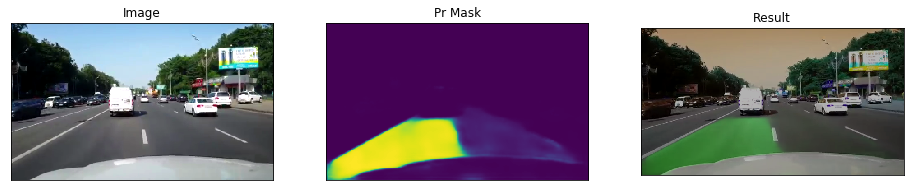

In [12]:
visualize(
    image=denormalize(frame.squeeze()),
    pr_mask=pr_mask[..., 0].squeeze(),
    result=segmented_result,
)

### Test on images of a sidewalk

  0%|          | 0/3 [00:00<?, ?it/s]

(1, 192, 320, 3)
[INFO] single frame of size (192, 320) took 0.2052 seconds


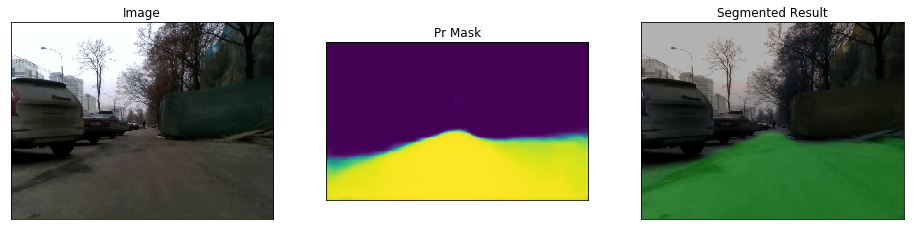

 33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

(1, 192, 320, 3)
[INFO] single frame of size (192, 320) took 0.1968 seconds


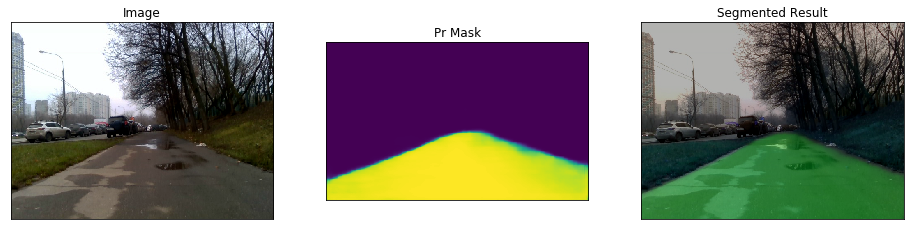

 67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

(1, 192, 320, 3)
[INFO] single frame of size (192, 320) took 0.2002 seconds


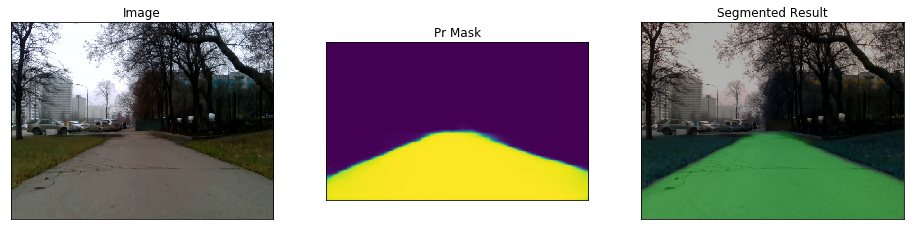

100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

[INFO] Mean FPS 4.9833 Hz


In [13]:
PATH_TO_FRAMES = 'frames/images'
FPS = []
for im_path in tqdm( os.listdir(PATH_TO_FRAMES)[:3] ):
    # get raw frames from video stream
    frame_raw = cv2.imread(os.path.join(PATH_TO_FRAMES, im_path))
    
    # preprocess raw frames
    frame = image_preprocessing(frame_raw)
    print(frame.shape)
    # predict segmentation mask from the frame
    start = time.time()
    pr_mask = model.predict(frame)
    end = time.time()
    dt = end-start
    FPS.append(1./dt)
    segmented_result = visual_seg_result(frame_raw[:,:,(2,1,0)], pr_mask)
    print("[INFO] single frame of size {} took {:.4f} seconds".format(frame.shape[1:3], dt))

    visualize(
        image=denormalize(frame_raw[:,:,(2,1,0)]),
        pr_mask=pr_mask.squeeze(),
        segmented_result=segmented_result
    )

print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))
